In [ ]:
'''
author: 梁泽涛，叶文涛
create time: 2020-7-16
update time: 2020-7-25
'''

In [11]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import re
import os,gc,time,re,datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# from pipeline.util import *
# from pipeline.preprocess import *
# from pipeline.config import *

In [2]:
%time train_data = pd.read_pickle('data/clean_data1.pkl')

Wall time: 5.14 s


In [16]:
test_data = pd.read_csv('./data/Btest0711_ALL.csv')
port_df = pd.read_csv('./data/port.csv')

test_data.drop_duplicates(inplace=True)
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'],infer_datetime_format=True).apply(lambda x: x.replace(tzinfo=None))
test_data['onboardDate'] = pd.to_datetime(test_data['onboardDate'],infer_datetime_format=True).apply(lambda x: x.replace(tzinfo=None))

test_data = test_data.sort_values(by=['loadingOrder','timestamp']).reset_index(drop=True)

test_data.loc[test_data.TRANSPORT_TRACE=='HUNGARY-HON','TRANSPORT_TRACE'] = 'SIKOP-HKHKG'
#test_data.loc[test_data.vesselMMSI=='R3419973056','vesselMMSI'] = 'W2722004813'
#test_data.loc[test_data.vesselMMSI=='X2692921717','vesselMMSI'] = 'Z8556231115'

# 处理port_df, 形成port_dict
port_df.drop(columns=['STATE','CITY','REGION','ADDRESS','PORT_CODE','TRANSPORT_NODE_ID'],inplace=True)
port_df.COUNTRY = port_df.COUNTRY.str.lower()
port_dict = {}
for idx,row in port_df.iterrows():
    port_dict[row['TRANS_NODE_NAME']] = [row['LONGITUDE'],row['LATITUDE']]

In [17]:
# haversine 经纬度球面距离
def Distance(LonA,LatA,LonB,LatB):
    EARTH_RADIUS = 6378.137 # 千米
    radLatA = np.radians(LatA)
    radLatB = np.radians(LatB)
    a = radLatA-radLatB
    b = np.radians(LonA)-np.radians(LonB)
    s= 2 * np.arcsin(np.sqrt(np.power(np.sin(a / 2),2)+ np.cos(radLatA) * np.cos(radLatB)*np.power(np.sin(b / 2),2))) * EARTH_RADIUS
    return s  

def trail_cut_v0(df,end_port):
    df.reset_index(drop=True,inplace=True)
    end_port_coord = port_dict[end_port]
    
    # 选取靠近终点港口的记录
    near_end_port_df = df[np.sqrt((df.longitude-end_port_coord[0])**2+(df.latitude-end_port_coord[1])**2)<0.4]
    if len(near_end_port_df)<=0:
        print('error 0，未靠近终点港口')
        return None
    
    # 取靠近终点港口的记录的第一点
    end_time = near_end_port_df.timestamp.values[0]
    # 取近港无0速度的 0.1分位点
    min_speed_near_end = near_end_port_df.speed[near_end_port_df.speed!=0].quantile(0.1)
    
    # 尝试获取近港速度中小于0.1分位点的速度中的首位
    if min_speed_near_end>=0:
        end_time = near_end_port_df[near_end_port_df.speed<=min_speed_near_end].timestamp.values[0]
        
    
    # 在靠近终点港口的记录中选取状态为moored的
    end_moored_df = near_end_port_df[near_end_port_df.vesselStatus=='moored']
    if len(end_moored_df)>0:
        end_time_idx = end_moored_df.index[0]
        # 尝试获取moored状态改变前的值
        try:
            end_time = near_end_port_df.timestamp[end_time_idx-1]
        except:
            print('error 1, 状态改变')
    
    # 近港时间间隔
    near_end_port_df['end_diff_hour'] = near_end_port_df.timestamp.diff(1).dt.total_seconds()/3600
    # 如果间隔时间大于6小时且为最大的，取该index
    end_time_idx_by_diff_hour = near_end_port_df.index[(near_end_port_df.end_diff_hour>6)&(near_end_port_df.end_diff_hour==near_end_port_df.end_diff_hour.max())]

    if len(end_time_idx_by_diff_hour)>0:
        # 尝试获取间隔时间大于6小时且为最大的间隔，的前5个点
        try:
            end_time_by_diff_hour = pd.to_datetime(near_end_port_df.timestamp[end_time_idx_by_diff_hour[0]-1]).tz_localize(None)
            end_time = min(pd.to_datetime(end_time).tz_localize(None),end_time_by_diff_hour)
        except:
            print('error 2， 时间间隔')

    
    # 选取最后的end_time
    end_time = pd.to_datetime(end_time).tz_localize(None)
    df['label'] = (end_time - df.timestamp.apply(lambda x: x.replace(tzinfo=None))).dt.total_seconds()
    # 返回截断df
    t = df.timestamp.apply(lambda x: x.replace(tzinfo=None))
    return df[t<=end_time]


# 路径截断算法
def trail_cut(df,end_port):
    df.reset_index(drop=True,inplace=True)
    end_port_coord = port_dict[end_port]

    # 选取靠近终点港口的记录
    near_end_port_df =  df[(np.abs(df.longitude-end_port_coord[0])<=0.25) & (np.abs(df.latitude-end_port_coord[1])<=0.25)]
    if len(near_end_port_df)<=0:
        #print('error 0，未靠近终点港口')
        return None

    end_time_base = near_end_port_df.timestamp.values[0]
    end_time = end_time_base
    
    # 到港距离
    near_end_port_df['dist_to_port'] = Distance(near_end_port_df['longitude'],near_end_port_df['latitude'],end_port_coord[0],end_port_coord[1])
    # 以周为单位切分近港记录
    near_end_port_df['week'] = near_end_port_df.timestamp.values - near_end_port_df.timestamp.values[0]
    near_end_port_df['week'] = near_end_port_df['week'].dt.days//7
    
    #对每个周分区遍历，最终end_time取较大的值
    for weeki in range(near_end_port_df['week'].max()+1):
        weeki_df = near_end_port_df[near_end_port_df.week == weeki].reset_index(drop = True)
        # 如果weeki_df非空，则遍历weeki_df寻找连续距离减小的点，取较早的值
        if not weeki_df.empty:
            dist = weeki_df.iloc[0]['dist_to_port']
            continue_dist_decrese_count = 0
            for index,row in weeki_df.iterrows():
                if row['dist_to_port']<dist:
                    continue_dist_decrese_count+=1
                else:
                    continue_dist_decrese_count = 0
                    
                dist = row['dist_to_port'] # 取新值作为dist
                
                # 连续5行都距离减小，则视为找到
                if continue_dist_decrese_count==5:
                    end_time = weeki_df.iloc[index-3].timestamp # 取中间值作为到港，注意在大循环中，此值可能被覆盖
                    break
    
    # 展示新旧打标算法的差别
    if weeki>0:
        print(end_time_base, 'vs', end_time)
    

    end_time = pd.to_datetime(end_time).tz_localize(None)
    df['label'] = (end_time - df.timestamp.apply(lambda x: x.replace(tzinfo=None))).dt.total_seconds()
    # 返回截断df
    t = df.timestamp.apply(lambda x: x.replace(tzinfo=None))
    return df[t<=end_time]



# 全量采样
def order_sample(df,alpha=0.5):
    order = df.loadingOrder.values[0]
    # 采样点的数量
    '''sample_size = max(1,int(df.shape[0]**alpha))
    df = df.reset_index(drop=True)
    sample_idx = np.random.choice(np.arange(df.shape[0]),size=sample_size,replace=False)
    df = df.iloc[sample_idx].reset_index(drop=True)
    '''
    global tmp_arrival_time
    arrival_time = tmp_arrival_time[order]
    
    df['label'] = (arrival_time - df.timestamp.apply(lambda x: x.replace(tzinfo=None))).dt.total_seconds()
    
    return df

# 获取特征
def get_feature(df,end_port):
    
    def cut_trace(t,end_port):
        t = t.split('-')
        idx = t.index(end_port)
        return '-'.join(t[:idx+1])
    
    df['trace'] = df['TRANSPORT_TRACE'].apply(lambda x:cut_trace(x,end_port))
    df['trace_len'] = df['trace'].apply(lambda x:len(x.split('-')))
    
    end_p = port_dict[end_port]
    df['dist2end'] = Distance(df['longitude'],df['latitude'],end_p[0],end_p[1])
    df['end_port_long_sin'] = np.sin(np.radians(end_p[0]))
    df['end_port_long_cos'] = np.cos(np.radians(end_p[0]))
    df['end_port_lat'] = np.radians(end_p[1])
    
    df['long_sin'] = np.sin(np.radians(df['longitude']))
    df['long_cos'] = np.cos(np.radians(df['longitude']))
    df['lat'] = np.radians(df['latitude'])
    
    cols = ['loadingOrder','carrierName','timestamp','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat',
            'label']
    
    return df[cols]



In [6]:
# 将test_data的终点港口存入集合
end_port_set = set()
for trace in test_data.TRANSPORT_TRACE.unique():
    end_port_set.add(trace.split('-')[-1])
    
# 找到每个end_port对应的route
end_port_route_dict = dict()
tmp_lst = train_data.TRANSPORT_TRACE.unique()  # 如果不先存，则每次循环都会读取调用一次train_data.TRANSPORT_TRACE.unique()

# 二重遍历，处理整个终点港与所有路由， 生成{终点港：路由}的字典
for end_port in end_port_set:
    for route in tmp_lst:
        if(re.match(f'.*-{end_port}.*', route)):
            # 如果没有键就生成，如果有就append
            if end_port_route_dict.get(end_port):
                end_port_route_dict[end_port].append(route)
            else:
                end_port_route_dict[end_port] = [route]

In [7]:
train_ft = []
i = 0
for end_port in tqdm(end_port_set):
    # 获取含有终点港口end_port的路由的数据, 且不为起始港口
    tmp_data = train_data[train_data.TRANSPORT_TRACE.isin(end_port_route_dict[end_port])].reset_index(drop=True)   
    
    # 调用trail_cut函数
    tmp_data = tmp_data.groupby(by='loadingOrder').apply(trail_cut, end_port).reset_index(drop=True)
    # 采样
    # %time tmp_data = tmp_data.groupby(by='loadingOrder').apply(order_sample,2/3).reset_index(drop=True)
    if tmp_data.empty:
        print('船只没有接近此终点港')
        continue
    # 生成特征
    tmp_data = get_feature(tmp_data,end_port).reset_index(drop=True)
    train_ft.append(tmp_data)
    

train_ft = pd.concat(train_ft,axis=0) 
train_ft = train_ft.sort_values(by=['loadingOrder','timestamp']).reset_index(drop=True)

  2%|█▌                                                                                 | 1/52 [00:04<03:30,  4.12s/it]

2019-09-01T02:15:41.000000000 vs 2019-09-08 15:06:02+00:00
2019-06-29T23:29:18.000000000 vs 2019-07-07 02:14:04+00:00
2019-12-10T05:07:22.000000000 vs 2019-12-17 05:56:13+00:00
2020-01-05T01:52:08.000000000 vs 2020-01-12 03:47:11+00:00
2019-09-01T02:15:41.000000000 vs 2019-09-08 15:06:02+00:00
2019-12-24T14:55:49.000000000 vs 2020-01-01 02:21:26+00:00
2019-06-29T23:30:24.000000000 vs 2019-07-07 02:14:04+00:00
2019-06-29T23:30:24.000000000 vs 2019-07-07 02:14:04+00:00
2020-03-29T04:38:07.000000000 vs 2020-04-05 04:51:32+00:00


  8%|██████▍                                                                            | 4/52 [00:18<03:29,  4.37s/it]

2019-11-27T12:19:53.000000000 vs 2019-12-04 13:36:07+00:00


 19%|███████████████▊                                                                  | 10/52 [00:45<02:17,  3.28s/it]

2020-04-07T19:39:10.000000000 vs 2020-04-19 18:31:37+00:00


 23%|██████████████████▉                                                               | 12/52 [00:50<01:46,  2.67s/it]

2019-08-03T14:54:37.000000000 vs 2019-08-27 04:21:06+00:00


 37%|█████████████████████████████▉                                                    | 19/52 [01:19<01:21,  2.47s/it]

2020-03-01T14:46:36.000000000 vs 2020-03-10 15:28:07+00:00


 42%|██████████████████████████████████▋                                               | 22/52 [02:00<03:29,  7.00s/it]

2020-04-04T01:54:03.000000000 vs 2020-04-11 05:23:24+00:00
2019-08-16T02:28:06.000000000 vs 2019-08-24 08:56:29+00:00
2019-09-27T15:15:00.000000000 vs 2019-09-27 15:17:06+00:00
2019-10-02T06:33:31.000000000 vs 2019-10-09 11:50:03+00:00
2019-11-28T06:22:30.000000000 vs 2019-11-28 06:30:29+00:00
2020-04-09T06:26:17.000000000 vs 2020-04-22 02:33:18+00:00
2020-04-04T01:47:06.000000000 vs 2020-04-11 05:15:21+00:00
2020-04-04T01:47:06.000000000 vs 2020-04-11 05:15:21+00:00


 77%|███████████████████████████████████████████████████████████████                   | 40/52 [03:09<01:02,  5.22s/it]

2020-04-09T17:47:16.000000000 vs 2020-04-18 20:51:29+00:00
2020-04-09T17:47:16.000000000 vs 2020-04-18 20:51:29+00:00


 87%|██████████████████████████████████████████████████████████████████████▉           | 45/52 [03:31<00:26,  3.84s/it]

2020-02-24T23:03:08.000000000 vs 2020-03-03 21:43:40+00:00


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 49/52 [03:38<00:05,  1.86s/it]

2019-12-02T20:01:56.000000000 vs 2019-12-12 06:03:18+00:00
2020-03-01T15:56:37.000000000 vs 2020-03-08 18:02:08+00:00
2020-01-18T07:20:42.000000000 vs 2020-01-31 18:21:15+00:00
2019-01-27T08:17:02.000000000 vs 2019-01-27 08:25:13+00:00
2020-03-18T00:51:34.000000000 vs 2020-03-18 00:57:03+00:00


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [03:59<00:00,  4.61s/it]


In [8]:
train_ft

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label
0,AA191175561416,OIEQNT,2019-01-28 16:12:59+00:00,Y7540547327,CNYTN-MXZLO,2,13785.268122,0.911688,-0.410884,0.393939,-0.968992,-0.247093,0.333113,2248789.0
1,AA191175561416,OIEQNT,2019-01-28 16:22:38+00:00,Y7540547327,CNYTN-MXZLO,2,13785.258647,0.911687,-0.410885,0.393940,-0.968992,-0.247093,0.333113,2248210.0
2,AA191175561416,OIEQNT,2019-01-28 16:30:55+00:00,Y7540547327,CNYTN-MXZLO,2,13785.205371,0.911685,-0.410889,0.393948,-0.968992,-0.247093,0.333113,2247713.0
3,AA191175561416,OIEQNT,2019-01-28 16:37:35+00:00,Y7540547327,CNYTN-MXZLO,2,13785.235477,0.911688,-0.410884,0.393946,-0.968992,-0.247093,0.333113,2247313.0
4,AA191175561416,OIEQNT,2019-01-28 16:45:56+00:00,Y7540547327,CNYTN-MXZLO,2,13785.213197,0.911686,-0.410888,0.393947,-0.968992,-0.247093,0.333113,2246812.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001804,ZZ586794005049,OIEQNT,2019-02-03 22:31:23+00:00,O2545136013,CNYTN-BRSSZ,2,31.364029,-0.723521,0.690302,-0.422902,-0.722774,0.691084,-0.418085,1002.0
10001805,ZZ586794005049,OIEQNT,2019-02-03 22:35:52+00:00,O2545136013,CNYTN-BRSSZ,2,29.557997,-0.723600,0.690220,-0.422589,-0.722774,0.691084,-0.418085,733.0
10001806,ZZ586794005049,OIEQNT,2019-02-03 22:39:32+00:00,O2545136013,CNYTN-BRSSZ,2,28.141615,-0.723663,0.690153,-0.422338,-0.722774,0.691084,-0.418085,513.0
10001807,ZZ586794005049,OIEQNT,2019-02-03 22:43:23+00:00,O2545136013,CNYTN-BRSSZ,2,26.736105,-0.723726,0.690087,-0.422084,-0.722774,0.691084,-0.418085,282.0


In [18]:
# 存储训练集
# train_ft.to_pickle('data/train_ft_我打标.pkl')
%time train_ft = pd.read_pickle('data/train_ft_原cooper打标.pkl')

Wall time: 3.11 s


In [19]:
# 测试集全量采样
def test_order_sample(df):
    order = df.loadingOrder.values[0]
    '''sample_size = max(1,int(df.shape[0]**(2/3)))
    df = df.reset_index(drop=True)
    sample_idx = np.random.choice(np.arange(df.shape[0]),size=sample_size,replace=False)
    df = df.iloc[sample_idx].reset_index(drop=True)'''
    return df
def get_test_feature(df):
    df['trace'] = df['TRANSPORT_TRACE']
    df['trace_len'] = df['TRANSPORT_TRACE'].apply(lambda x:len(x.split('-')))
    df['end_port_long'] = df['TRANSPORT_TRACE'].apply(lambda x:port_dict[x.split('-')[-1]][0])
    df['end_port_lat'] = df['TRANSPORT_TRACE'].apply(lambda x:port_dict[x.split('-')[-1]][1])
    
    df['end_port_long_sin'] = np.sin(np.radians(df['end_port_long']))
    df['end_port_long_cos'] = np.cos(np.radians(df['end_port_long']))
    
    df['long_sin'] = np.sin(np.radians(df['longitude']))
    df['long_cos'] = np.cos(np.radians(df['longitude']))
    df['lat'] = np.radians(df['latitude'])
    
    df['dist2end'] = Distance(df['longitude'],df['latitude'],df['end_port_long'],df['end_port_lat'])
    df['end_port_lat'] = np.radians(df['end_port_lat'])
    cols = ['loadingOrder','carrierName','timestamp','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat']
    
    return df[cols]

In [20]:
'''# continue after arrival
# 将对应运单对应时间之后的数据删掉
CAA_test_order_dict = {}
CAA_test_order_dict['FA712454830300'] = '2020-01-28 07:22:48'
CAA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'

#given answer
GA_test_order_dict = {}
GA_test_order_dict['VT660611547333'] = '2020-03-13 23:39:28'
GA_test_order_dict['BR663094574600'] = '2020-06-01 21:08:03'
GA_test_order_dict['KD265061648304'] = '2020-06-01 14:31:43'
GA_test_order_dict['TI854412328664'] = '2020-06-01 05:29:08'
GA_test_order_dict['JE319829909965'] = '2020-01-04 17:34:28'
GA_test_order_dict['PK422158256377'] = '2020-06-01 23:58:15'
GA_test_order_dict['NO206755451873'] = '2020-06-01 00:05:50'
GA_test_order_dict['NI245305422658'] = '2020-06-01 00:06:57'
GA_test_order_dict['NH835931693561'] = '2020-03-13 23:39:28'
GA_test_order_dict['LR291426429726'] = '2020-04-28 00:03:18'
GA_test_order_dict['KL671073399431'] = '2020-06-01 00:08:13'
GA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'

# 将对应运单对应时间之后的数据删掉
for o in CAA_test_order_dict:
    test_data = test_data[~((test_data.loadingOrder==o)&(test_data.timestamp>pd.to_datetime(CAA_test_order_dict[o])))]
test_data = test_data.reset_index(drop=True)'''

"# continue after arrival\n# 将对应运单对应时间之后的数据删掉\nCAA_test_order_dict = {}\nCAA_test_order_dict['FA712454830300'] = '2020-01-28 07:22:48'\nCAA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'\n\n#given answer\nGA_test_order_dict = {}\nGA_test_order_dict['VT660611547333'] = '2020-03-13 23:39:28'\nGA_test_order_dict['BR663094574600'] = '2020-06-01 21:08:03'\nGA_test_order_dict['KD265061648304'] = '2020-06-01 14:31:43'\nGA_test_order_dict['TI854412328664'] = '2020-06-01 05:29:08'\nGA_test_order_dict['JE319829909965'] = '2020-01-04 17:34:28'\nGA_test_order_dict['PK422158256377'] = '2020-06-01 23:58:15'\nGA_test_order_dict['NO206755451873'] = '2020-06-01 00:05:50'\nGA_test_order_dict['NI245305422658'] = '2020-06-01 00:06:57'\nGA_test_order_dict['NH835931693561'] = '2020-03-13 23:39:28'\nGA_test_order_dict['LR291426429726'] = '2020-04-28 00:03:18'\nGA_test_order_dict['KL671073399431'] = '2020-06-01 00:08:13'\nGA_test_order_dict['DH829189593918'] = '2020-01-16 23:49:48'\n\n# 将对应运单对应时间之后

In [21]:
test_ft = test_data.groupby(by='loadingOrder').apply(test_order_sample).reset_index(drop=True)
test_ft = get_test_feature(test_ft).reset_index(drop=True)

In [22]:
%time all_ft = pd.concat([train_ft,test_ft],axis=0,sort=False).reset_index(drop=True)
# 合并船只特征
# all_ft = pd.merge(all_ft,vessel_feature,how='left',on='vesselMMSI')

# 对类别特征 labelencode
cat_cols = ['carrierName','vesselMMSI','trace']
for c in cat_cols:
    lb_encoder = LabelEncoder()
    %time all_ft[c] = lb_encoder.fit_transform(all_ft[c])

Wall time: 30.2 s
Wall time: 1.67 s
Wall time: 1.66 s
Wall time: 1.91 s


In [23]:
features = ['carrierName','vesselMMSI','trace','trace_len',
            'dist2end',
            'long_sin','long_cos','lat','end_port_long_sin','end_port_long_cos','end_port_lat']# + vessel_stat_cols
train_x = all_ft[~all_ft.label.isnull()].reset_index(drop=True)
test_x = all_ft[all_ft.label.isnull()].reset_index(drop=True)
train_y = train_ft.label
print(features)

['carrierName', 'vesselMMSI', 'trace', 'trace_len', 'dist2end', 'long_sin', 'long_cos', 'lat', 'end_port_long_sin', 'end_port_long_cos', 'end_port_lat']


In [ ]:
# 特征分布，需要时间较长
plt.subplots(3,4,figsize=(20,15))
for idx,col in enumerate(features):
    #if col == 'trace_len':
        #continue
    plt.subplot(3,4,idx+1)
    plt.title(col)
    sns.kdeplot(train_x[col],label='train')
    sns.kdeplot(test_x[col],label='test')

In [15]:
# 打标
all_ft['is_test'] = 0
all_ft.loc[all_ft.label.isnull(), 'is_test'] = 1
all_ft

,loadingOrder,carrierName,timestamp,vesselMMSI,trace,trace_len,dist2end,long_sin,long_cos,lat,end_port_long_sin,end_port_long_cos,end_port_lat,label,is_test
0,AA191175561416,12,2019-01-28 16:12:59+00:00,888,224,2,13785.268122,0.911688,-0.410884,0.393939,-0.968992,-0.247093,0.333113,2248789.0,0
1,AA191175561416,12,2019-01-28 16:22:38+00:00,888,224,2,13785.258647,0.911687,-0.410885,0.393940,-0.968992,-0.247093,0.333113,2248210.0,0
2,AA191175561416,12,2019-01-28 16:30:55+00:00,888,224,2,13785.205371,0.911685,-0.410889,0.393948,-0.968992,-0.247093,0.333113,2247713.0,0
3,AA191175561416,12,2019-01-28 16:37:35+00:00,888,224,2,13785.235477,0.911688,-0.410884,0.393946,-0.968992,-0.247093,0.333113,2247313.0,0
4,AA191175561416,12,2019-01-28 16:45:56+00:00,888,224,2,13785.213197,0.911686,-0.410888,0.393947,-0.968992,-0.247093,0.333113,2246812.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10053625,ZX687996032865,22,2020-06-11 23:50:22,661,97,2,1745.657288,0.881381,-0.472405,0.409954,0.802545,-0.596592,0.652785,NaN,1
10053626,ZX687996032865,22,2020-06-11 23:52:28,661,97,2,1744.660568,0.881299,-0.472559,0.410051,0.802545,-0.596592,0.652785,NaN,1
10053627,ZX687996032865,22,2020-06-11 23:54:10,661,97,2,1743.819169,0.881233,-0.472682,0.410136,0.802545,-0.596592,0.652785,NaN,1
10053628,ZX687996032865,22,2020-06-11 23:56:40,661,97,2,1742.572301,0.881135,-0.472864,0.410262,0.802545,-0.596592,0.652785,NaN,1


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.990392
[100]	valid_0's auc: 0.995609
[150]	valid_0's auc: 0.997141
[200]	valid_0's auc: 0.997786
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.997786
AUC:  0.997786296315257
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.990446
[100]	valid_0's auc: 0.995403
[150]	valid_0's auc: 0.996858
[200]	valid_0's auc: 0.997648
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.997648
AUC:  0.9976480255110025
AUC_mean:  0.997717


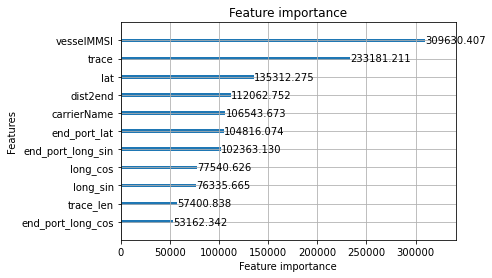

In [16]:
# 对抗验证模型构建及CV
def build_model_adv(train, features, label, seed=666, is_shuffle=True):
    train_pred = np.zeros((train.shape[0], ))
    n_splits = 2
    eval_score = 0
    # Kfold
    fold = StratifiedKFold(n_splits=n_splits, shuffle=is_shuffle, random_state=seed)
    kf_way = fold.split(train[features], train[label])
    # params
    params = {
            'boosting_type': 'gbdt',   # 传统梯度提升树类型
            'max_depth': 7,  # 树的最大深度，减少可降低过拟合
            'num_leaves': 31, # 叶子数量，取值应 <= 2 ^（max_depth）， 超过此值容易导致过拟合
            'objective': 'binary',  # binary用作二分类，regression用于回归，multiclass用于多分类
            'metric': 'auc',  # 衡量指标，可选有cross_entropy, binary_logloss,auc等
            'learning_rate': 0.1,
            'min_data_in_leaf':20,  # 叶子具有的最小记录数，默认为20，设置较大能减少树的深度，但有可能导致欠拟合
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 20,
            'reg_alpha': 3.77, 
            'reg_lambda': 5.86,
}
    # train
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        train_x, train_y = train[features].iloc[train_idx], train[label].iloc[train_idx]
        valid_x, valid_y = train[features].iloc[valid_idx], train[label].iloc[valid_idx]
        # 数据加载
        n_train = lgb.Dataset(train_x, label=train_y)
        n_valid = lgb.Dataset(valid_x, label=valid_y)
        
        eval_results = {}
        
        clf = lgb.train(
            params=params,
            train_set=n_train,
            num_boost_round=200,
            valid_sets=[n_valid],
            evals_result = eval_results, 
            early_stopping_rounds=50,
            verbose_eval=50,
        )
        train_pred[valid_idx] += clf.predict(valid_x, num_iteration=clf.best_iteration)
        print("AUC: ", eval_results['valid_0']['auc'][clf.best_iteration-1])
        eval_score += eval_results['valid_0']['auc'][clf.best_iteration-1]
        
    # Feature importance
    print("AUC_mean: ", round(eval_score/n_splits,6))  
    
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    train['is_test_predict'] = train_pred
    return train

# 预测是测试集的概率
data2 = build_model_adv(all_ft, features, 'is_test', is_shuffle=True)

In [17]:
train = data2[data2['is_test']==0].sort_values(by=['is_test_predict'], ascending=False).reset_index(drop=True)
test = data2[data2['is_test']==1].reset_index(drop=True)
valid = train[:round(train.shape[0]/10)]
train = train[round(train.shape[0]/10):]

fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 5.25476e+09	valid_0's l1: 43306.7
[200]	valid_0's l2: 3.99273e+09	valid_0's l1: 36184.2
[300]	valid_0's l2: 3.54343e+09	valid_0's l1: 32965
[400]	valid_0's l2: 3.27343e+09	valid_0's l1: 30845.8
[500]	valid_0's l2: 3.11609e+09	valid_0's l1: 29630.7
[600]	valid_0's l2: 3.01638e+09	valid_0's l1: 28875.3
[700]	valid_0's l2: 2.9278e+09	valid_0's l1: 28152.8
[800]	valid_0's l2: 2.86653e+09	valid_0's l1: 27557.2
[900]	valid_0's l2: 2.81027e+09	valid_0's l1: 26971.8
[1000]	valid_0's l2: 2.76134e+09	valid_0's l1: 26504.8
[1100]	valid_0's l2: 2.72448e+09	valid_0's l1: 26135.2
[1200]	valid_0's l2: 2.69512e+09	valid_0's l1: 25866.3
[1300]	valid_0's l2: 2.66937e+09	valid_0's l1: 25598.3
[1400]	valid_0's l2: 2.64832e+09	valid_0's l1: 25422.5
[1500]	valid_0's l2: 2.6293e+09	valid_0's l1: 25214.9
[1600]	valid_0's l2: 2.61162e+09	valid_0's l1: 25056.7
[1700]	valid_0's l2: 2.59733e+09	valid_0's l1: 24880.2
[1800]	v

[4500]	valid_0's l2: 2.42368e+09	valid_0's l1: 23005.6
[4600]	valid_0's l2: 2.42268e+09	valid_0's l1: 22989.6
[4700]	valid_0's l2: 2.42148e+09	valid_0's l1: 22974.3
[4800]	valid_0's l2: 2.42084e+09	valid_0's l1: 22957.7
[4900]	valid_0's l2: 2.4189e+09	valid_0's l1: 22944
[5000]	valid_0's l2: 2.41818e+09	valid_0's l1: 22933.7
Did not meet early stopping. Best iteration is:
[5000]	valid_0's l2: 2.41818e+09	valid_0's l1: 22933.7
Evaluated only: l2
mse:  2418177887.9230266
mse_mean:  2427940306.585631
mse_std:  10332778.954269
test_label均值 256.6797386537817
train_label均值 229.45415899548874
Wall time: 1h 10min 56s


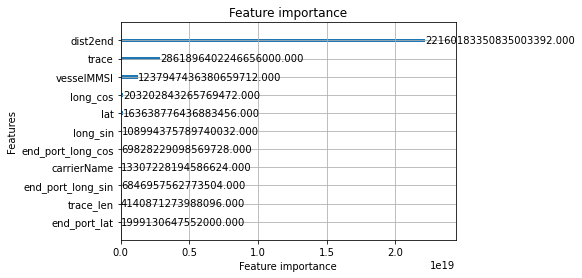

In [32]:
# 五折
params1 = {   # cooper参数
    'seed':2020666,
    'boosting_type': 'gbdt',
    'objective': 'regression', 
    'metric': ['l2','l1'],
    'first_metric_only':True,
    'learning_rate': 0.1,
    'max_depth': 10,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'reg_lambda': 1, # l2 惩罚
    'num_boost_round':5000,
    'verbose':100,
    'early_stopping_rounds':100,
}
params = {  # 我参数
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'huber',   #huber增强平方误差损失函数(MSE)对噪声的鲁棒性。
    'metric': ['l2', 'l1'],
    # 'metric': ['huber'],
    'first_metric_only':True,
    'num_leaves': 36,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.7,
    'bagging_freq': 6,
    'seed': 8,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'nthread': 8,
    'verbose': 100,
}

def asymmetric_mse(preds, train_data):
    y_pred = preds
    y_true = train_data.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*np.e*residual, -2*residual)
    hess = np.where(residual<0, 2*np.e, 2.0)
    return grad, hess

def run_lgb_kfold(train_X,train_Y,test_X,lgb_params,feature_name,split=3,seed=2020666,cat_cols='auto'):
    
    train_pred = np.zeros(train_X.shape[0])
    test_pred = np.zeros(test_X.shape[0])
    eval_score = []
    
    seeds=range(seed,seed+split)
    
    train_val_spliter = KFold(n_splits=split, random_state=seeds[0], shuffle=True)
    # train_val_spliter = GroupKFold(n_splits=split)
    # gkf = GroupKFold(n_splits=split) 
    # for index, (train_index, test_index) in enumerate(gkf.split(train_X, train_Y, groups=train_X['loadingOrder'])):
    
    for index, (train_index, test_index) in enumerate(train_val_spliter.split(train_X, train_Y)):
        print('fold:',index+1)
        lgb_params['seed'] = seeds[index]
        eval_results = {}
        #切分每轮的训练集和验证集
        train_x, val_x, train_y, val_y = train_X[feature_name].iloc[train_index], train_X[feature_name].iloc[test_index], train_Y.iloc[train_index], train_Y.iloc[test_index]
        
        train_data = lgb.Dataset(train_x,label=train_y)
        val_data = lgb.Dataset(val_x,label=val_y)
        
        lgb_model=lgb.train(lgb_params,train_data,valid_sets=[val_data],valid_names=['valid_0'],
                            evals_result = eval_results,
                            verbose_eval=lgb_params['verbose'],
                            categorical_feature=cat_cols,
                            learning_rates=lambda iter:0.1 * (0.9995**iter),
                           fobj=asymmetric_mse)
        gc.collect()
        
        train_pred[test_index] += lgb_model.predict(val_x[feature_name])
        fold_test_pred = lgb_model.predict(test_X[feature_name])
        
        test_pred += fold_test_pred/split
        
        print("mse: ", eval_results['valid_0']['l2'][lgb_model.best_iteration-1])
        eval_score.append(eval_results['valid_0']['l2'][lgb_model.best_iteration-1])
    
    print("mse_mean: ", round(np.mean(eval_score),6)) 
    print("mse_std: ", round(np.std(eval_score),6)) 

    lgb.plot_importance(lgb_model, max_num_features = 20,importance_type='gain')
    test_X['label'] = test_pred
    train_X['label'] = train_pred
    
    print('test_label均值',np.mean(test_X['label']/3600))
    print('train_label均值',np.mean(train_X['label']/3600))
    # return train_pred,test_pred
    return test_X[['loadingOrder', 'label']]

# 五折
%time result = run_lgb_kfold(train_x,train_y,test_x,params1,features,cat_cols=cat_cols)

In [18]:
def mse_score_eval(preds, valid):
    labels = valid.get_label()
    scores = mean_squared_error(y_true=labels/3600, y_pred=preds/3600)
    return 'mse_score', scores, False

def asymmetric_mse(preds, train_data):
    y_pred = preds
    y_true = train_data.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*np.e*residual, -2*residual)
    hess = np.where(residual<0, 2*np.e, 2.0)
    return grad, hess

def build_model_once(train, valid, test, features, label, seed=1080, is_shuffle=True):
    params = {
        'learning_rate': 0.1,
        'boosting_type': 'gbdt',
        'objective': 'huber',   #huber增强平方误差损失函数(MSE)对噪声的鲁棒性。
        'metric': ['l2', 'l1'],
        # 'metric': ['huber'],
        'first_metric_only':True,
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'nthread': 8,
        'verbose': 1,
        'device':'cpu'
    }
    
    # 数据加载
    n_train = lgb.Dataset(train[features], label=train[label])
    n_valid = lgb.Dataset(valid[features], label=valid[label])
    
    clf = lgb.train(
        params=params,
        train_set=n_train,
        num_boost_round=10000,
        valid_sets=[n_valid],
        early_stopping_rounds=100,
        verbose_eval=100,
        # feval=mse_score_eval,
        fobj=asymmetric_mse,
        learning_rates=lambda iter:0.1 * (0.9995**iter),
    )
    # 打印特征重要度
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    
    test['label'] = clf.predict(test[features], num_iteration=clf.best_iteration)
    
    # print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test[label]/3600))
    print('train_label均值',np.mean(train[label]/3600))
    return test[['loadingOrder', 'label']]


def build_model_once_without_valid(train, test, features, label, seed=1080, is_shuffle=True):
    params = {
        'learning_rate': 0.1,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': ['l2', 'l1'],
        'first_metric_only':True,
        'num_leaves': 36,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.7,
        'bagging_freq': 6,
        'seed': 8,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'nthread': 8,
        'verbose': 1,
        'device':'cpu'
    }
    
    # 数据加载
    n_train = lgb.Dataset(train[features], label=train[label])
    
    clf = lgb.train(
        params=params,
        train_set=n_train,
        num_boost_round=10000,
        verbose_eval=100,
        # feval=mse_score_eval,
        fobj=asymmetric_mse,
        learning_rates=lambda iter:0.1 * (0.9995**iter),
    )
    # 打印特征重要度
    lgb.plot_importance(clf, max_num_features = 20, importance_type = 'gain')
    
    test['label'] = clf.predict(test[features], num_iteration=clf.best_iteration)
    
    # print('oof MSE: ',mean_squared_error(train[label]/3600,train_pred/3600))
    print('test_label均值',np.mean(test[label]/3600))
    print('train_label均值',np.mean(train[label]/3600))
    return test[['loadingOrder', 'label']]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.70521e+10	valid_0's l1: 85580.8
[200]	valid_0's l2: 1.34068e+10	valid_0's l1: 77498.7
[300]	valid_0's l2: 1.19348e+10	valid_0's l1: 73108.6
[400]	valid_0's l2: 1.10142e+10	valid_0's l1: 70254.3
[500]	valid_0's l2: 1.05828e+10	valid_0's l1: 68592.3
[600]	valid_0's l2: 1.01187e+10	valid_0's l1: 67117.5
[700]	valid_0's l2: 9.76008e+09	valid_0's l1: 65823.7
[800]	valid_0's l2: 9.57236e+09	valid_0's l1: 64975.2
[900]	valid_0's l2: 9.37415e+09	valid_0's l1: 64126.4
[1000]	valid_0's l2: 9.24464e+09	valid_0's l1: 63475
[1100]	valid_0's l2: 9.11401e+09	valid_0's l1: 62913
[1200]	valid_0's l2: 9.00794e+09	valid_0's l1: 62488.2
[1300]	valid_0's l2: 8.92705e+09	valid_0's l1: 62066.4
[1400]	valid_0's l2: 8.84758e+09	valid_0's l1: 61680.8
[1500]	valid_0's l2: 8.77894e+09	valid_0's l1: 61289.6
[1600]	valid_0's l2: 8.71703e+09	valid_0's l1: 60988.9
[1700]	valid_0's l2: 8.6648e+09	valid_0's l1: 60729.5
[1800]	valid_0's 

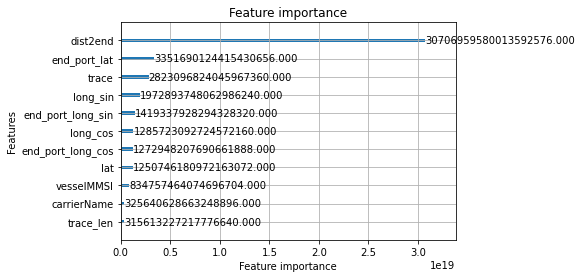

In [26]:
# baseline（cooper打标）
%time result = build_model_once(train, valid, test, features, 'label', is_shuffle=True)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.85441e+10	valid_0's l1: 88205.7
[200]	valid_0's l2: 1.44948e+10	valid_0's l1: 79317.1
[300]	valid_0's l2: 1.28032e+10	valid_0's l1: 74579.2
[400]	valid_0's l2: 1.21414e+10	valid_0's l1: 72476.4
[500]	valid_0's l2: 1.14448e+10	valid_0's l1: 70060
[600]	valid_0's l2: 1.11434e+10	valid_0's l1: 68850.8
[700]	valid_0's l2: 1.08492e+10	valid_0's l1: 67739
[800]	valid_0's l2: 1.06155e+10	valid_0's l1: 66779.1
[900]	valid_0's l2: 1.04886e+10	valid_0's l1: 66077.2
[1000]	valid_0's l2: 1.03647e+10	valid_0's l1: 65577.5
[1100]	valid_0's l2: 1.02809e+10	valid_0's l1: 65265
[1200]	valid_0's l2: 1.02296e+10	valid_0's l1: 64977.3
[1300]	valid_0's l2: 1.01359e+10	valid_0's l1: 64460.3
[1400]	valid_0's l2: 1.01176e+10	valid_0's l1: 64443.2
[1500]	valid_0's l2: 1.00602e+10	valid_0's l1: 64123.6
[1600]	valid_0's l2: 1.00091e+10	valid_0's l1: 63829.1
[1700]	valid_0's l2: 9.93071e+09	valid_0's l1: 63524.6
[1800]	valid_0's l

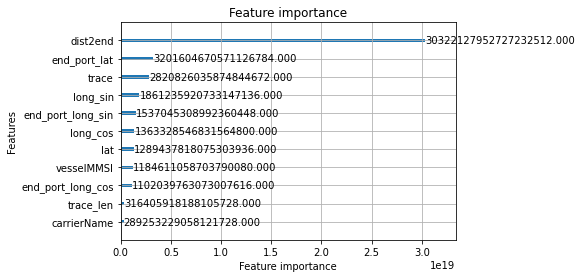

In [19]:
# 我打标
%time result = build_model_once(train, valid, test, features, 'label', is_shuffle=True)

test_label均值 264.38342797227193
train_label均值 232.39834326040454
Wall time: 56min 56s


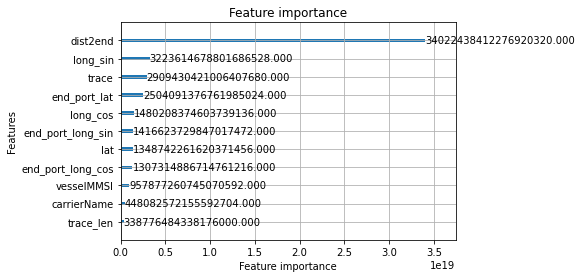

In [15]:
# 全量梭哈
%time result = build_model_once_without_valid(train_x, test_x, features, 'label', is_shuffle=True)

In [27]:
8.03674e+09/3600/3600

620.1188271604939

In [33]:
test_order_pred = test_x[['loadingOrder','timestamp','dist2end']]
test_order_pred['pred'] = result['label']
test_order_pred['ETA'] = test_order_pred['timestamp'] + test_order_pred['pred'].apply(lambda x:pd.Timedelta(seconds=x))

'''# 打印与答案的对比
tmp_result = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())[GA_test_order_dict.keys()]
score = 0
for o in GA_test_order_dict:
    score += ((tmp_result[o]-pd.to_datetime(GA_test_order_dict[o])).total_seconds()/3600)**2
print(score/len(GA_test_order_dict))
print(tmp_result,GA_test_order_dict)'''

d:\tools\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\tools\python\lib\site-packages\pandas\core\arrays\datetimelike.py:1268: PerformanceWarning: Adding/subtracting array of DateOffsets to TimedeltaArray not vectorized
  PerformanceWarning,
d:\tools\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


"# 打印与答案的对比\ntmp_result = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())[GA_test_order_dict.keys()]\nscore = 0\nfor o in GA_test_order_dict:\n    score += ((tmp_result[o]-pd.to_datetime(GA_test_order_dict[o])).total_seconds()/3600)**2\nprint(score/len(GA_test_order_dict))\nprint(tmp_result,GA_test_order_dict)"

In [34]:
result2 = test_order_pred.groupby(by='loadingOrder')['ETA'].apply(lambda x:x.mean())

'''# 附上正确答案
for o in GA_test_order_dict:
    result2[o] = pd.to_datetime(GA_test_order_dict[o])'''

result2 = pd.merge(pd.read_csv('data/Btest0711_ALL.csv'),result2,how='left',on='loadingOrder')
result2['ETA'] = result2['ETA'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
result2['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

result2 = result2[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

d:\tools\python\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [35]:
now = datetime.datetime.now()
result2.to_csv('result/result_{0}-{1}-{2}_{3}-{4}.csv'.format(now.year,now.month,now.day,now.hour,now.minute), index=False)
result2

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,NJ169522947117,2019-12-30T06:23:18.000Z,110.760670,12.794997,OIEQNT,V1990211048,2019/12/28 20:28:18,2020/01/01 12:59:02,2020/08/10 09:35:24
1,NJ169522947117,2019-12-30T06:23:18.000Z,110.760670,12.794997,OIEQNT,V1990211048,2019/12/28 20:28:18,2020/01/01 12:59:02,2020/08/10 09:35:24
2,NJ169522947117,2019-12-30T13:13:18.000Z,110.463333,11.181667,OIEQNT,V1990211048,2019/12/28 20:28:18,2020/01/01 12:59:02,2020/08/10 09:35:24
3,NJ169522947117,2019-12-30T13:13:18.000Z,110.463333,11.181667,OIEQNT,V1990211048,2019/12/28 20:28:18,2020/01/01 12:59:02,2020/08/10 09:35:24
4,NJ169522947117,2019-12-30T23:57:48.000Z,108.592292,8.129657,OIEQNT,V1990211048,2019/12/28 20:28:18,2020/01/01 12:59:02,2020/08/10 09:35:24
...,...,...,...,...,...,...,...,...,...
57066,OY547556724291,2020-06-24T22:24:49.000Z,112.964717,16.577832,YAAWEN,I5822271034,2020/06/24 02:59:00,2020/06/27 11:26:10,2020/08/10 09:35:24
57067,OY547556724291,2020-06-24T22:36:15.000Z,112.949566,16.516350,YAAWEN,I5822271034,2020/06/24 02:59:00,2020/06/27 11:26:10,2020/08/10 09:35:24
57068,OY547556724291,2020-06-24T22:36:26.000Z,112.949570,16.516350,YAAWEN,I5822271034,2020/06/24 02:59:00,2020/06/27 11:26:10,2020/08/10 09:35:24
57069,OY547556724291,2020-06-24T22:47:58.000Z,112.930867,16.455133,YAAWEN,I5822271034,2020/06/24 02:59:00,2020/06/27 11:26:10,2020/08/10 09:35:24


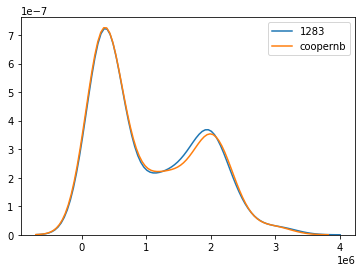

In [51]:
def cal_label(df):
    onboardDate = df.groupby('loadingOrder')['onboardDate'].agg(mmax='max').reset_index()
    ETA=df.groupby('loadingOrder')['ETA'].agg(mmax='max').reset_index()
    return (pd.to_datetime(ETA['mmax'])-pd.to_datetime(onboardDate['mmax'])).dt.total_seconds()

new=cal_label(result2)
# sns.kdeplot(new,label='new')

# sns.kdeplot(cal_label(pd.read_csv('result/result_2020-8-8_17-18.csv')),label='1856')# cooper打标带验证集
sns.kdeplot(cal_label(pd.read_csv('result/result_2020-8-8_19-9.csv')),label='1283') # cooper打标全量
# sns.kdeplot(cal_label(pd.read_csv('result/result_2020-8-9_21-29.csv')),label='wo')# 我打标
sns.kdeplot(cal_label(pd.read_csv('result/result_2020-8-10_9-35.csv')),label='coopernb')# 三折改参数